## <font color='gold'/>**Install and Import**

In [1]:
!pip install \
    --requirement ../input/cellpose-wheels/requirements.txt \
    --no-index \
    --find-links ../input/cellpose-wheels/wheels

Looking in links: ../input/cellpose-wheels/wheels
Processing /kaggle/input/cellpose-wheels/wheels/torch-1.7.1+cu110-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/cellpose-wheels/wheels/torchvision-0.8.2+cu110-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/cellpose-wheels/wheels/torchaudio-0.7.2-cp37-cp37m-manylinux1_x86_64.whl
Processing /kaggle/input/cellpose-wheels/wheels/cellpose-2.0.4-py3-none-any.whl
Processing /kaggle/input/cellpose-wheels/wheels/fastremap-1.12.2-cp37-cp37m-manylinux2010_x86_64.whl
Processing /kaggle/input/cellpose-wheels/wheels/natsort-8.1.0-py3-none-any.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
  Attempting uninstall: torchaudio
    Found existing installation: torchau

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import imageio
import matplotlib.pyplot as plt
from cellpose import models
from tqdm import tqdm
%matplotlib inline

## <font color='gold'/>**Utility functions**

In [3]:
# Run Length Encode an instance
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [4]:
# Init model
cp_model_path = '../input/sartorius-weight/cellpose_250622_concat_epoch_500'
sz_model_path = '../input/sartorius-weight/cellpose_250622_concat_epoch_500_size.npy'

model = models.CellposeModel(gpu=True, pretrained_model=cp_model_path, concatenation=True)
sz_model = models.SizeModel(cp_model=model, pretrained_size=sz_model_path)

# Model configuration
channels = [0, 0]  # segment grayscale image

In [5]:
test_dir = glob.glob('../input/sartorius-cell-instance-segmentation/test/*.png')
image_names, pred_annots = [], []

for file_name in tqdm(test_dir):
    img = imageio.imread(file_name)
    img_name = file_name.split('/')[-1].split('.')[0]
    predicted_diam, _ = sz_model.eval(img, channels=channels)
    masks, flows, _ = model.eval(img, diameter=predicted_diam, channels=channels, augment=True)
    
    for i in range(1, masks.max() + 1):
        pred_annot = rle_encode(masks == i)
        image_names.append(img_name)
        pred_annots.append(pred_annot)

100%|██████████| 3/3 [00:06<00:00,  2.05s/it]


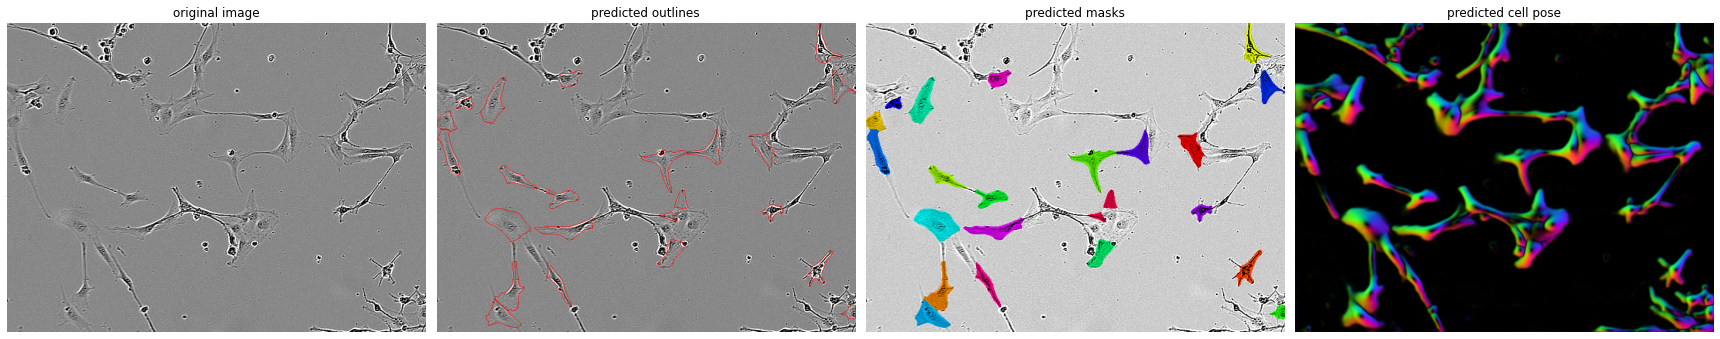

In [6]:
# Display result
from cellpose import plot

fig = plt.figure(figsize=(24, 8))
plot.show_segmentation(fig, img, masks, flows[0], channels=channels)
plt.tight_layout()
plt.show()

In [7]:
pd.DataFrame({'id': image_names, 'predicted': pred_annots}).sort_values(['id']).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head(20)

,id,predicted
0,7ae19de7bc2a,62 9 761 14 1461 18 2164 19 2867 20 3570 20 42...
1,7ae19de7bc2a,248078 10 248782 19 249487 22 250192 23 250898...
2,7ae19de7bc2a,243011 1 243710 8 244413 10 245116 13 245821 1...
3,7ae19de7bc2a,235046 2 235745 8 236446 12 237149 15 237853 1...
4,7ae19de7bc2a,234559 3 235263 5 235967 7 236672 8 237376 10 ...
5,7ae19de7bc2a,224983 7 225682 16 226383 20 227085 22 227787 ...
6,7ae19de7bc2a,224917 3 225620 7 226322 11 227023 15 227726 1...
7,7ae19de7bc2a,219840 2 220543 6 221247 8 221952 9 222657 10 ...
8,7ae19de7bc2a,210160 6 210863 9 211566 10 212269 12 212972 1...
9,7ae19de7bc2a,209959 4 210663 10 211366 16 212068 21 212770 ...
